## Instalando dependencias necesarias

In [1]:
%%capture
%pip install -U sentence-transformers pandas
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import os
import torch
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Entendiendo el dataset

In [3]:
# https://www.kaggle.com/datasets/omarhanyy/imdb-top-1000?resource=download
# TODO: Cargar el archivo del dataset con  pandas
read = pd.read_csv('/content/drive/MyDrive/Desarrollo de proyecto IA/IMDB top 1000.csv')
print(read.head())

   Unnamed: 0                                              Title Certificate  \
0           0                 1. The Shawshank Redemption (1994)           R   
1           1                            2. The Godfather (1972)           R   
2           2                          3. The Dark Knight (2008)       PG-13   
3           3                   4. The Godfather: Part II (1974)           R   
4           4  5. The Lord of the Rings: The Return of the Ki...       PG-13   

  Duration                     Genre  Rate  Metascore  \
0  142 min                     Drama   9.3       80.0   
1  175 min              Crime, Drama   9.2      100.0   
2  152 min      Action, Crime, Drama   9.0       84.0   
3  202 min              Crime, Drama   9.0       90.0   
4  201 min  Action, Adventure, Drama   8.9       94.0   

                                         Description  \
0  Two imprisoned men bond over a number of years...   
1  The aging patriarch of an organized crime dyna...   
2  When 

In [4]:
read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1000 non-null   int64  
 1   Title        1000 non-null   object 
 2   Certificate  973 non-null    object 
 3   Duration     1000 non-null   object 
 4   Genre        1000 non-null   object 
 5   Rate         1000 non-null   float64
 6   Metascore    712 non-null    float64
 7   Description  1000 non-null   object 
 8   Cast         1000 non-null   object 
 9   Info         1000 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 78.2+ KB


In [5]:
read.describe()

,Unnamed: 0,Rate,Metascore
count,1000.000000,1000.000000,712.000000
mean,499.500000,8.097500,81.001404
std,288.819436,0.169566,9.811801
min,0.000000,8.000000,61.000000
25%,249.750000,8.000000,73.000000
50%,499.500000,8.000000,82.000000
75%,749.250000,8.100000,88.250000
max,999.000000,9.300000,100.000000


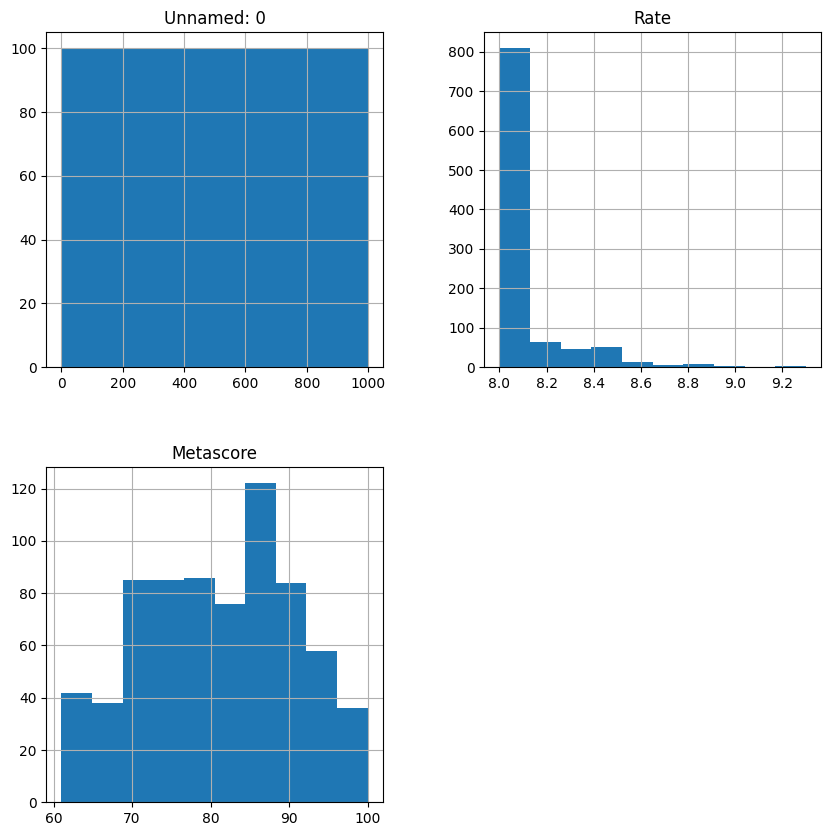

In [6]:
read.hist(figsize = (10,10),bins=10)
plt.show()

In [7]:
# TODO: mostrar los primeros 5 registros de dataframe

## Usando Sentence Transformer para crear embeddings

In [8]:
# Cargar el modelo de embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# Función principal
def main(query):
    # Cargar el archivo CSV
    df = read

    # Revisar las primeras filas del DataFrame
    print(df.head())

    # Eliminar filas duplicadas basadas en la columna 'Description'
    df = df.drop_duplicates(subset=['Description'], keep='first')

    # Usar la columna 'Description' para generar los embeddings
    descriptions = df['Description'].tolist()

    # Generar embeddings para las descripciones de las películas
    embeddings = model.encode(descriptions, batch_size=64, show_progress_bar=True)
    df['embeddings'] = embeddings.tolist()

    # Generar embedding para el término de búsqueda
    query_embedding = model.encode([query])[0]

    # Calcular la similitud entre el embedding de la búsqueda y los embeddings de las películas
    df['similarity'] = df.apply(lambda x: compute_similarity(x, query_embedding), axis=1)

    # Ordenar las películas por similitud (de mayor a menor)
    df = df.sort_values(by='similarity', ascending=False)

    # Mostrar las 5 películas más similares basadas en la descripción
    print("Películas más similares a tu búsqueda:")
    print(df[['Title', 'Description', 'similarity']].head())
    print("\n--- Fin de la búsqueda ---\n")


In [10]:
# Función para calcular la similitud
def compute_similarity(example, query_embedding):
    embedding = example['embeddings']
    similarity = util.cos_sim(embedding, query_embedding).item()
    return similarity

In [11]:
if __name__ == '__main__':
    while True:
        # Ingresar el término de búsqueda
        query = input('Ingresa el término de búsqueda (o escribe "salir" para terminar): ')

        if query.lower() == "salir":
            print("Saliendo del programa. ¡Hasta luego!")
            break

        # Llamar a la función principal
        main(query)

        # Preguntar si desea realizar otra búsqueda
        continuar = input("\n¿Quieres realizar otra búsqueda? (si/no): ").strip().lower()
        if continuar != "si":
            print("Saliendo del programa. ¡Hasta luego!")
            break

Ingresa el término de búsqueda (o escribe "salir" para terminar): romantic 
   Unnamed: 0                                              Title Certificate  \
0           0                 1. The Shawshank Redemption (1994)           R   
1           1                            2. The Godfather (1972)           R   
2           2                          3. The Dark Knight (2008)       PG-13   
3           3                   4. The Godfather: Part II (1974)           R   
4           4  5. The Lord of the Rings: The Return of the Ki...       PG-13   

  Duration                     Genre  Rate  Metascore  \
0  142 min                     Drama   9.3       80.0   
1  175 min              Crime, Drama   9.2      100.0   
2  152 min      Action, Crime, Drama   9.0       84.0   
3  202 min              Crime, Drama   9.0       90.0   
4  201 min  Action, Adventure, Drama   8.9       94.0   

                                         Description  \
0  Two imprisoned men bond over a number of 

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-9-74aa3af4b281>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embeddings'] = embeddings.tolist()
<ipython-input-9-74aa3af4b281>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similarity'] = df.apply(lambda x: compute_similarity(x, query_embedding), axis=1)


Películas más similares a tu búsqueda:
                              Title  \
310  313. Gone with the Wind (1939)   
325          328. La La Land (2016)   
320      323. Marriage Story (2019)   
298   301. Nights of Cabiria (1957)   
256   259. Chungking Express (1994)   

                                           Description  similarity  
310  A manipulative woman and a roguish man conduct...    0.403391  
325  While navigating their careers in Los Angeles,...    0.372691  
320  Noah Baumbach's incisive and compassionate loo...    0.337236  
298  A waifish prostitute wanders the streets of Ro...    0.317405  
256  Two melancholy Hong Kong policemen fall in lov...    0.314768  

--- Fin de la búsqueda ---


¿Quieres realizar otra búsqueda? (si/no): no
Saliendo del programa. ¡Hasta luego!
